In [1]:
# Looks like the BIC is makina a huge jump in the binwise showcase figure, which 
# indicates non-convergence. Investigate this.

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

import healpy as hp

import fig_gen as fg
import src.observing as OBS
import src.sky_models as SM
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.beam_functions as BF
import src.map_making as MM
from src.blockmat import BlockMatrix, BlockVector
import nregions_inference as NRI
nuarr = np.linspace(50,100,51)
from binwise_modelling import fg_cm21_chrom_corr

RS = SH.RealSphericalHarmonics()
from fig_gen import construct_runstr
from chainconsumer import ChainConsumer

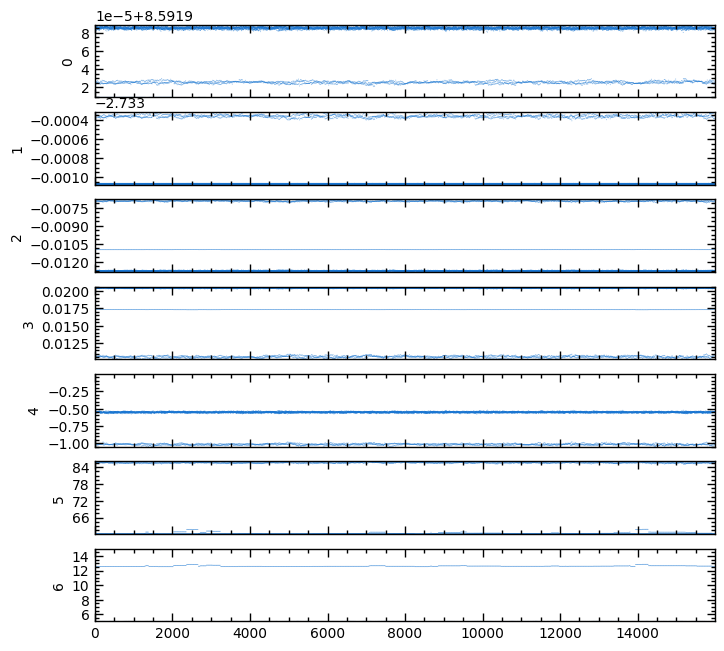

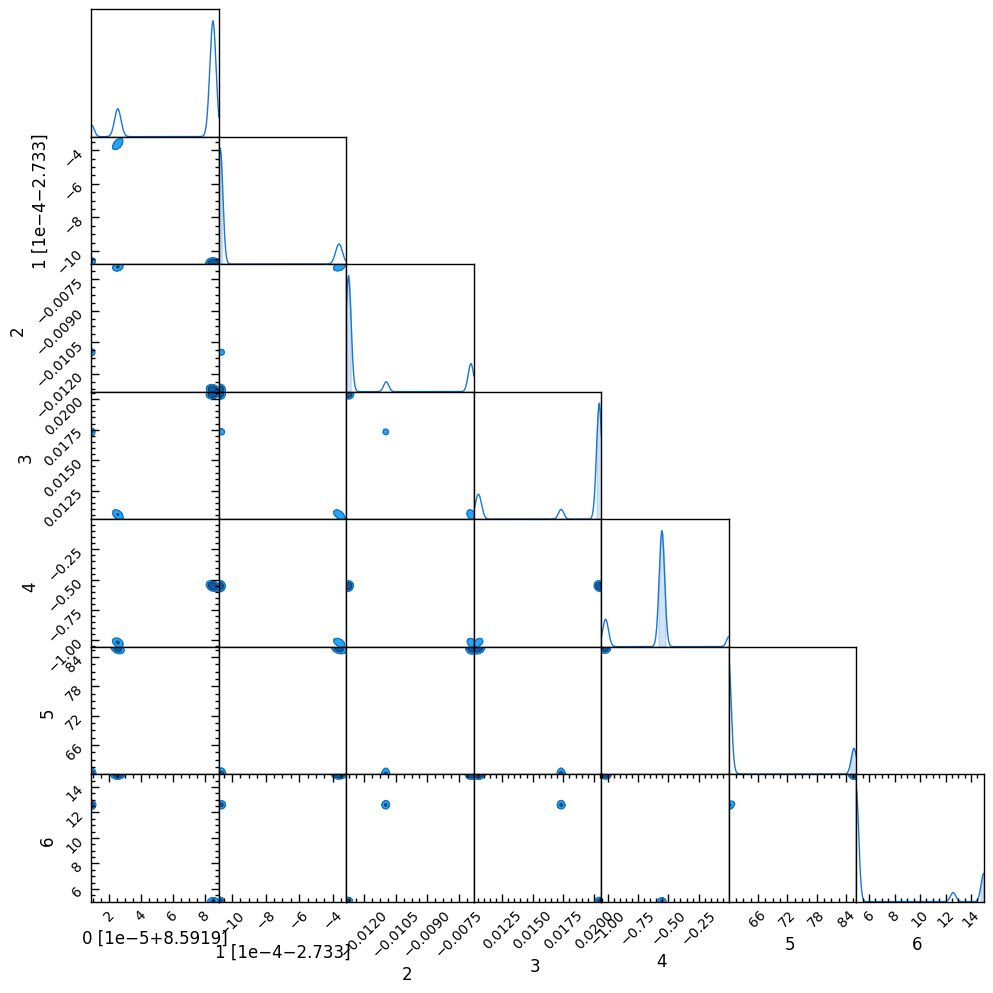

In [5]:
mcmcChain7 = np.load(
    'saves/Binwise/'
    +construct_runstr(Nant=7, Npoly=4, chromstr='1.6e-02', basemap_err=None)
    +'_mcmcChain.npy'
)
c = ChainConsumer().add_chain(mcmcChain7[::100])
f=c.plotter.plot_walks()
plt.show()
f=c.plotter.plot()
plt.show()

In [2]:
mcmcChain4 = np.load(
    'saves/Binwise/'
    +construct_runstr(Nant=7, Npoly=4, chromstr=None, basemap_err=None)
    +'_mcmcChain.npy'
)

In [13]:
mcmcChain4.shape

(1600000, 7)

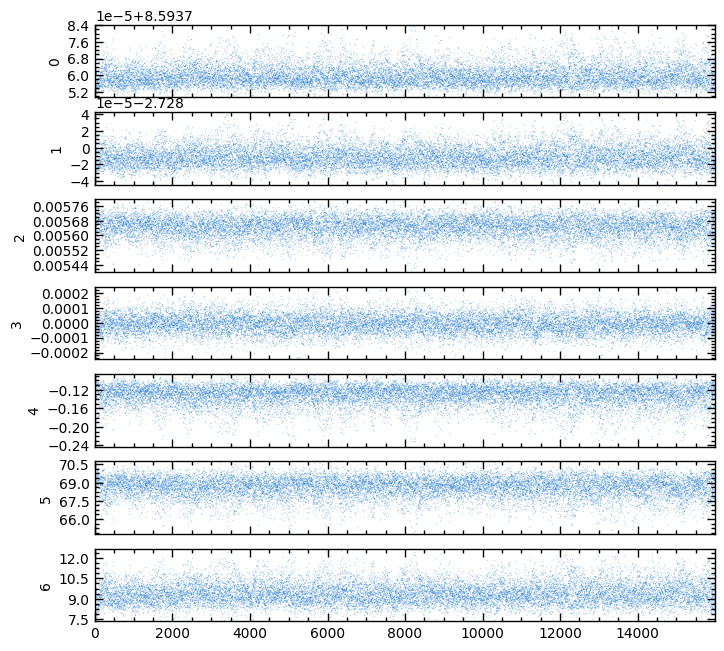

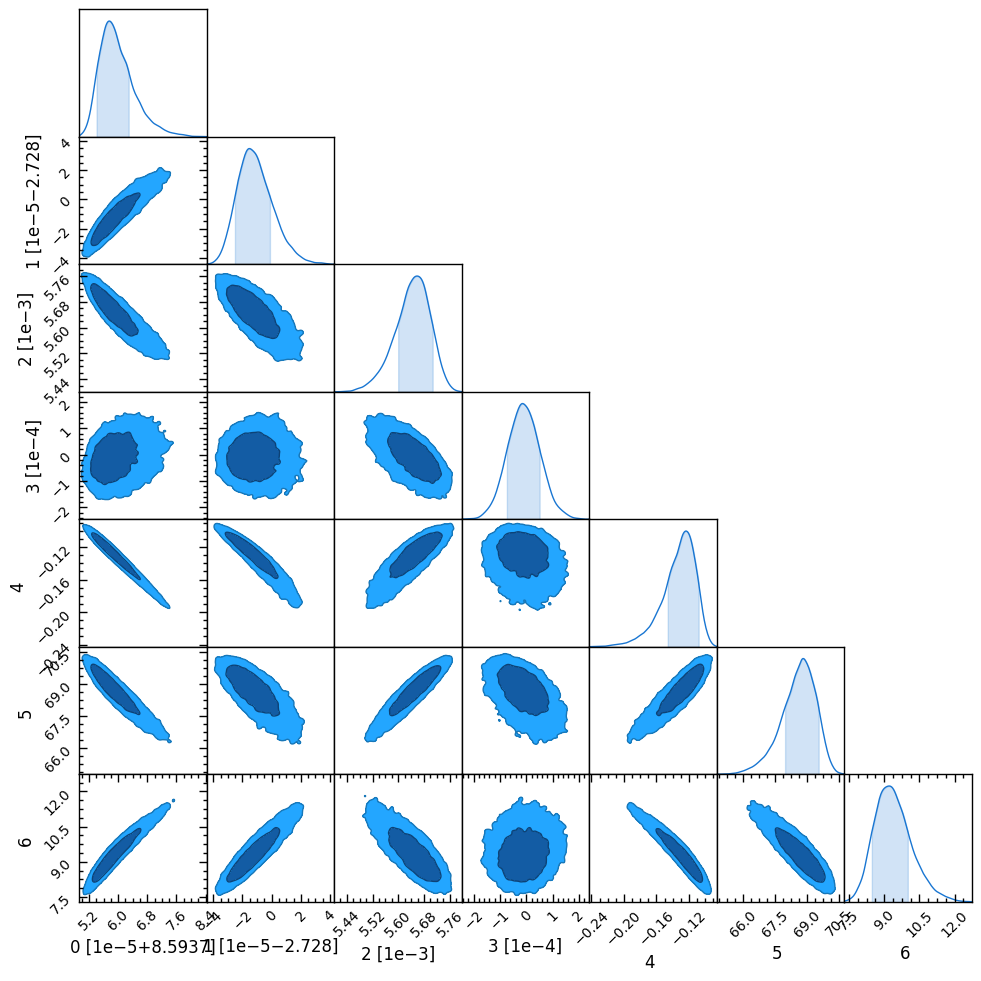

In [6]:
c = ChainConsumer().add_chain(mcmcChain4[::100])
f=c.plotter.plot_walks()
plt.show()
f=c.plotter.plot()
plt.show()

In [4]:
mcmcChain5 = np.load(
    'saves/Binwise/'
    +construct_runstr(Nant=7, Npoly=5, chromstr=None, basemap_err=None)
    +'_mcmcChain.npy'
)

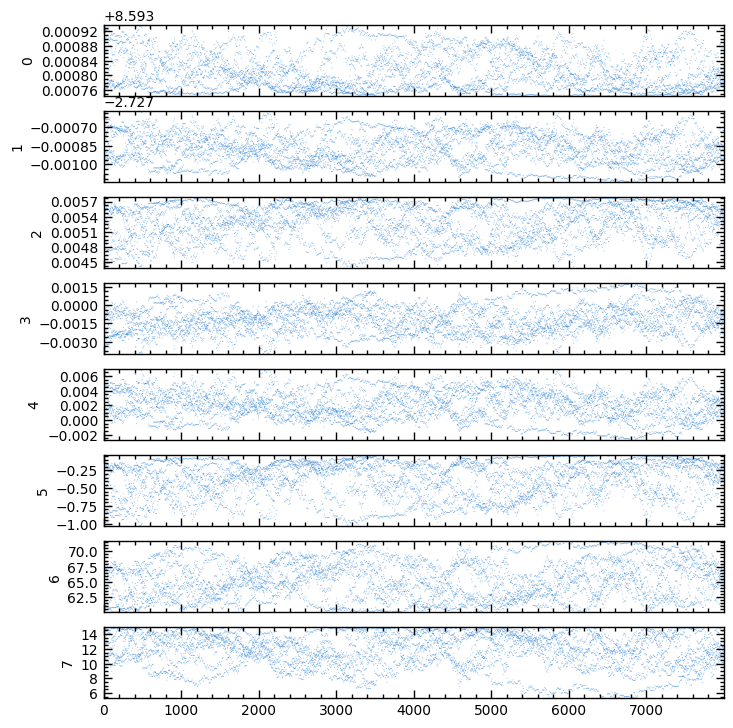

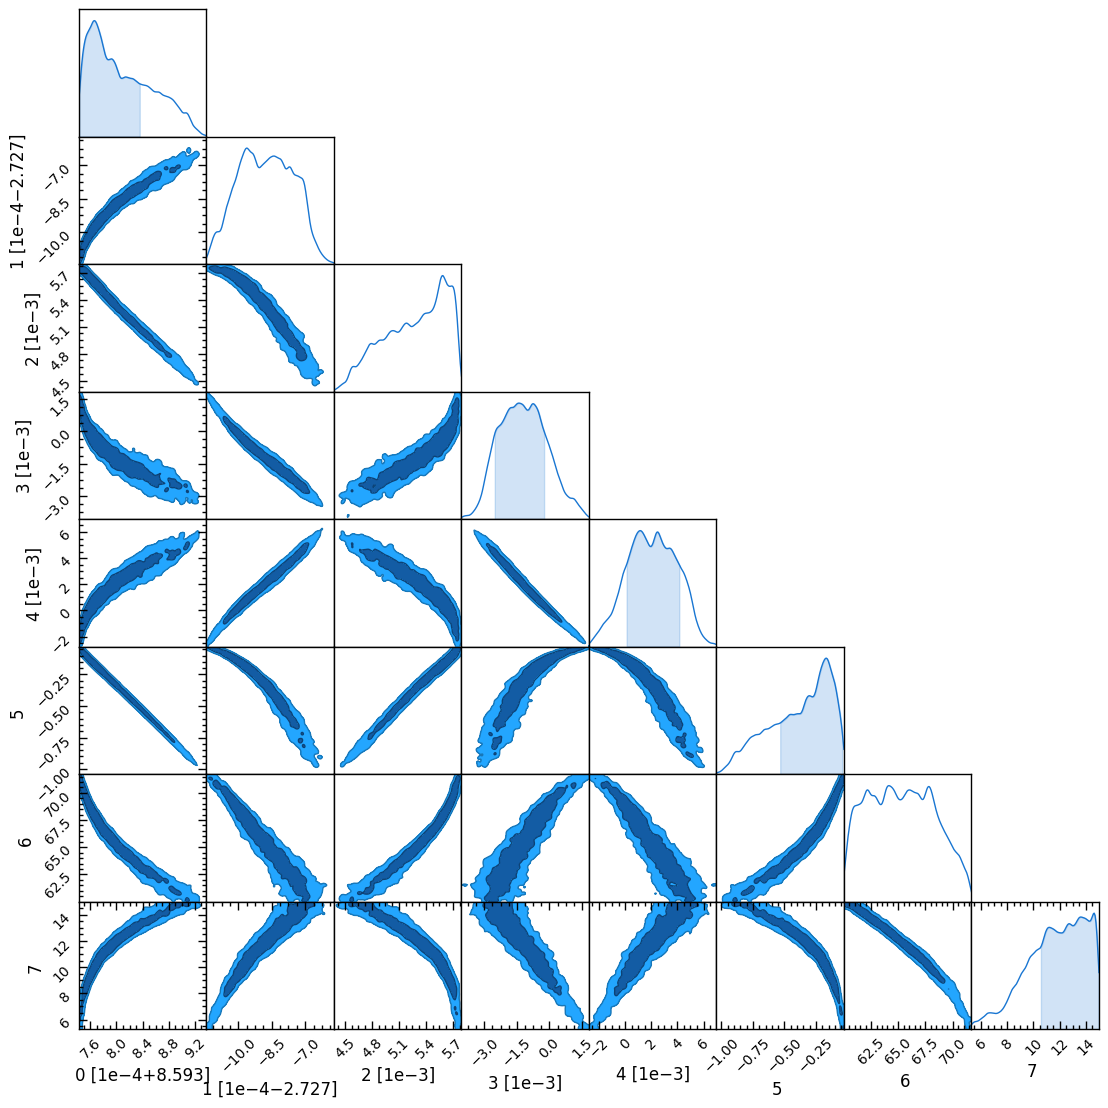

In [8]:
c = ChainConsumer().add_chain(mcmcChain5[::200])
f=c.plotter.plot_walks()
plt.show()
f=c.plotter.plot()
plt.show()

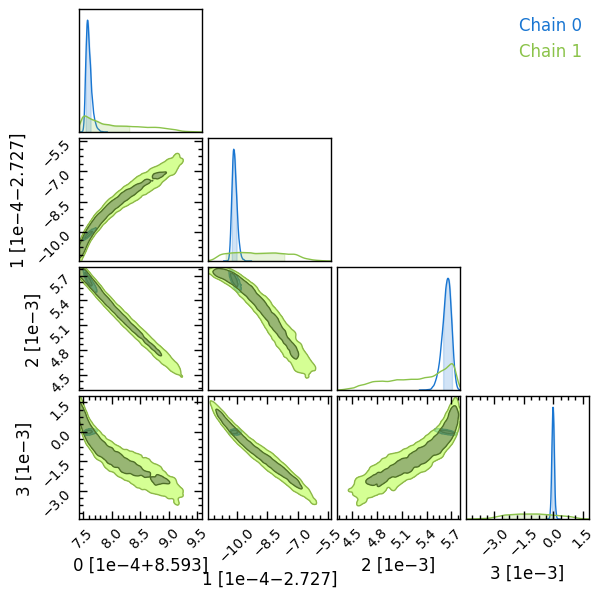

In [9]:
c = ChainConsumer().add_chain(mcmcChain4[::100,:4])
c.add_chain(mcmcChain5[::100,:4])
f=c.plotter.plot()
plt.show()

In [9]:
# Run a longer chain
fg.fg_cm21_chrom_corr(Npoly=5, mcmc=True, chrom=None, savetag='L', lats=fg.ant_LUT[7], mcmc_pos=None, basemap_err=None, steps=500000, burn_in=300000, fidmap_HS=False)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59374175e+00 -2.72818261e+00  5.68955394e-03  2.71331029e-03
 -3.98253362e-03]
std devs: [5.13575981e-07 4.62047467e-06 2.41217814e-05 1.47668847e-04
 2.13544561e-04]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [20:59<00:00, 396.96it/s]


bic is  56064.547561191685
saving bic


In [5]:
mcmcChain5L = np.load("saves/Binwise/Nant<7>_Npoly<5>_achromL_mcmcChain.npy")

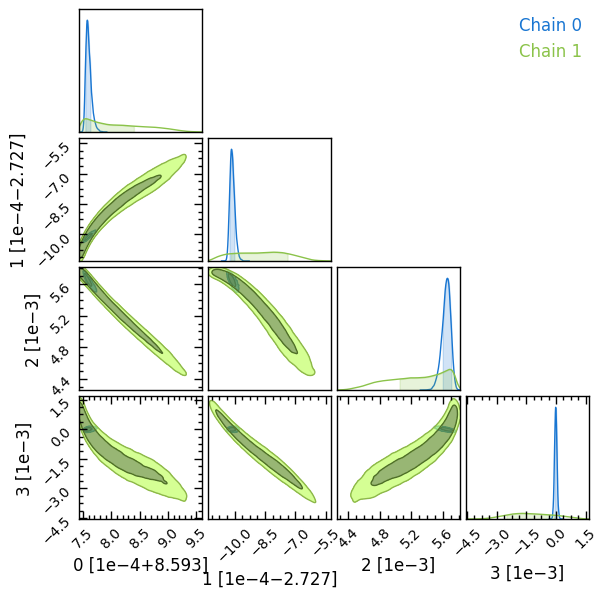

In [14]:
c = ChainConsumer().add_chain(mcmcChain4[::100,:4])
c.add_chain(mcmcChain5L[::100,:4])
f=c.plotter.plot()
plt.show()

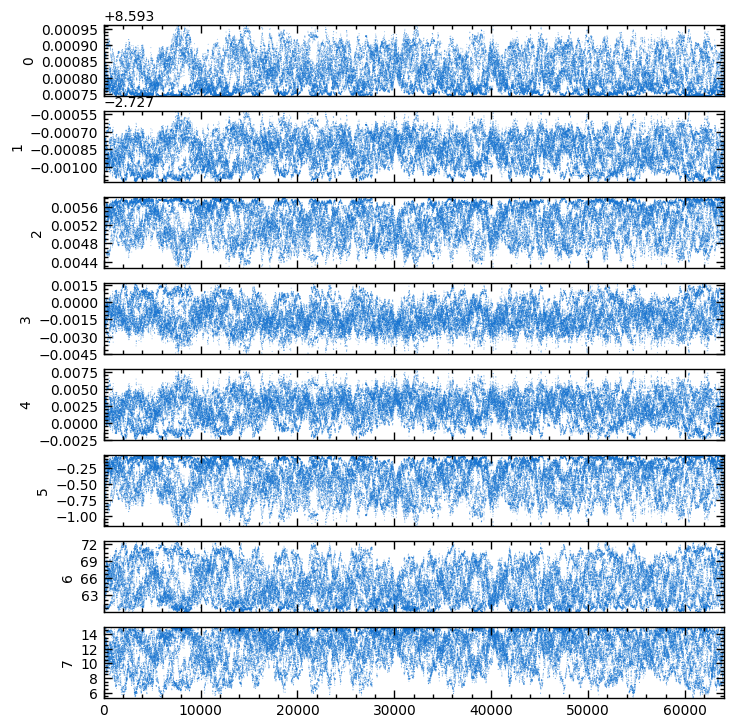

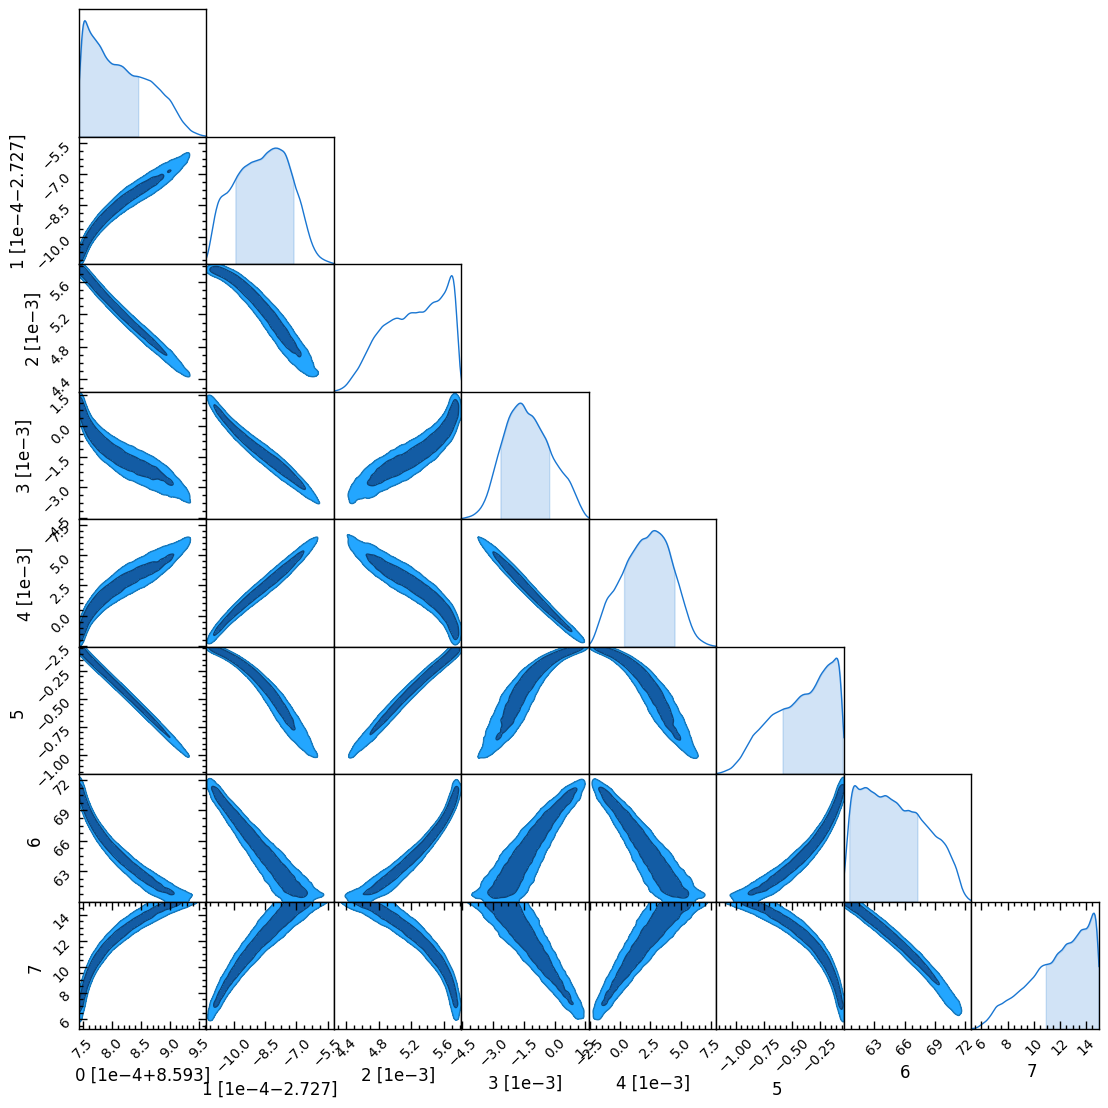

In [15]:
c = ChainConsumer().add_chain(mcmcChain5L[::200])
f=c.plotter.plot_walks()
plt.show()
f=c.plotter.plot()
plt.show()

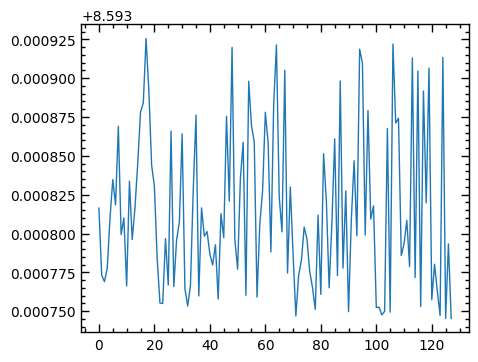

In [21]:
plt.plot(mcmcChain5L[::100000,0])

Want to set up these two models and their likelihoods so I can directly probe them.

In [23]:
import src.inference as INF
import nregions_inference as NRI

In [42]:
# LOAD UP NPOLY=4 MODEL
Npoly=4
chrom=None
basemap_err=None
savetag=None
times=None
lats=None
mcmc=False
mcmc_pos=None
steps=3000
burn_in=1000
fidmap_HS=False

# Model and observation params
nside   = 32
lmax    = 32
Nlmax   = RS.get_size(lmax)
if lats is None:
    lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])#np.linspace(-80, 80, 100)#[-26]#
if times is None:
    times = np.linspace(0, 24, 12, endpoint=False)
Ntau  = 1
nuarr = np.linspace(50,100,51)
cm21_params = OBS.cm21_params

# Generate foreground and 21-cm alm
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err), err_type='idx')
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
fid_alm  = fg_alm + cm21_alm

# Generate observation matrix for the observations.
# Generate observation matrix for the achromatic case.
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=True)
mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
mat_G = BlockMatrix(mat=mat_G, mode='block', nblock=len(nuarr))
mat_P = BlockMatrix(mat=mat_P, mode='block', nblock=len(nuarr))
mat_Y = BlockMatrix(mat=mat_Y, mode='block', nblock=len(nuarr))
mat_B = BlockMatrix(mat=mat_B, mode='block', nblock=len(nuarr))

# Perform fiducial observations without binning.
d = mat_P @ mat_Y @ mat_B @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, nuarr[1]-nuarr[0], len(times), t_int=200) # Ntau NOTE: using len(times) here because we keep the data unbinned to apply the chromaticity correction. Noise is recomputed later.
sample_noise = np.sqrt(noise_covar.block[0][0,0])
print(f"Data generated with noise {sample_noise} K at 50 MHz in the first bin")

dnoisy_vector = dnoisy.vector

# Bin the noisy data and the noise.
dnoisy = mat_G@dnoisy_vector
noise  = np.std([np.sqrt(np.diag(noise_covar.block[n])) for n in range(noise_covar.nblock)], axis=1)
noise_covar_binned = np.diag(noise)**2

# Set up the foreground model
mod4 = FM.genopt_binwise_cm21_forward_model(nuarr, mat_A, Npoly=Npoly)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin


In [7]:
# LOAD UP NPOLY=5 MODEL
Npoly=5
chrom=None
basemap_err=None
savetag=None
times=None
lats=None
mcmc=False
mcmc_pos=None
steps=3000
burn_in=1000
fidmap_HS=False

# Model and observation params
nside   = 32
lmax    = 32
Nlmax   = RS.get_size(lmax)
if lats is None:
    lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])#np.linspace(-80, 80, 100)#[-26]#
if times is None:
    times = np.linspace(0, 24, 12, endpoint=False)
Ntau  = 1
nuarr = np.linspace(50,100,51)
cm21_params = OBS.cm21_params

# Generate foreground and 21-cm alm
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err), err_type='idx')
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
fid_alm  = fg_alm + cm21_alm

# Generate observation matrix for the observations.
# Generate observation matrix for the achromatic case.
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=True)
mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
mat_G = BlockMatrix(mat=mat_G, mode='block', nblock=len(nuarr))
mat_P = BlockMatrix(mat=mat_P, mode='block', nblock=len(nuarr))
mat_Y = BlockMatrix(mat=mat_Y, mode='block', nblock=len(nuarr))
mat_B = BlockMatrix(mat=mat_B, mode='block', nblock=len(nuarr))

# Perform fiducial observations without binning.
d = mat_P @ mat_Y @ mat_B @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, nuarr[1]-nuarr[0], len(times), t_int=200) # Ntau NOTE: using len(times) here because we keep the data unbinned to apply the chromaticity correction. Noise is recomputed later.
sample_noise = np.sqrt(noise_covar.block[0][0,0])
print(f"Data generated with noise {sample_noise} K at 50 MHz in the first bin")

dnoisy_vector = dnoisy.vector

# Bin the noisy data and the noise.
dnoisy = mat_G@dnoisy_vector
noise  = np.std([np.sqrt(np.diag(noise_covar.block[n])) for n in range(noise_covar.nblock)], axis=1)
noise_covar_binned = np.diag(noise)**2

# Set up the foreground model
mod5 = FM.genopt_binwise_cm21_forward_model(nuarr, mat_A, Npoly=Npoly)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin


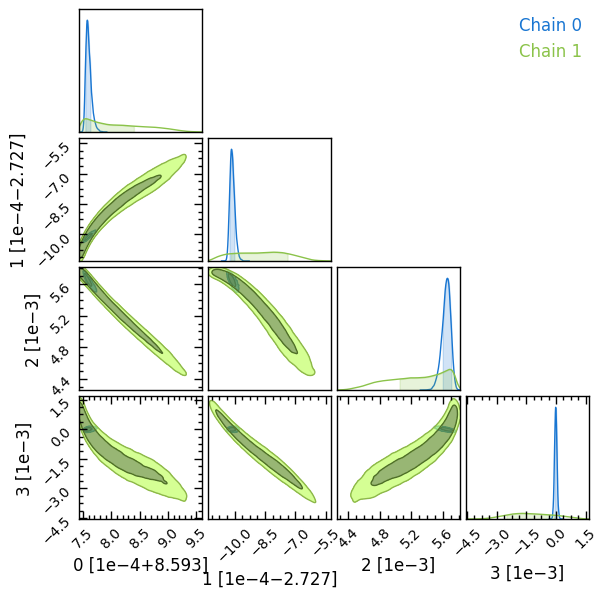

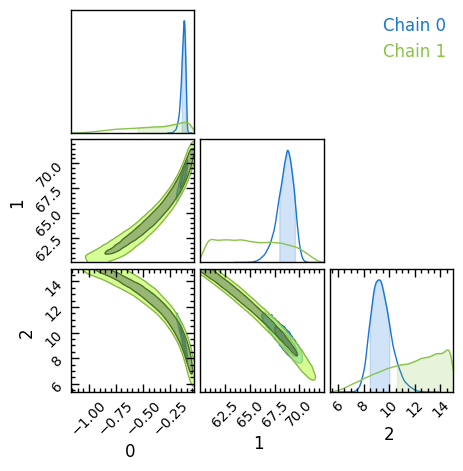

In [15]:
# VISUALISE BOTH MODEL'S CHAINS TOGETHER 
c = ChainConsumer().add_chain(mcmcChain4[::100,:4])
c.add_chain(mcmcChain5L[::100,:4])
f=c.plotter.plot()
plt.show()

c = ChainConsumer().add_chain(mcmcChain4[::100,-3:])
c.add_chain(mcmcChain5L[::100,-3:])
f=c.plotter.plot()
plt.show()

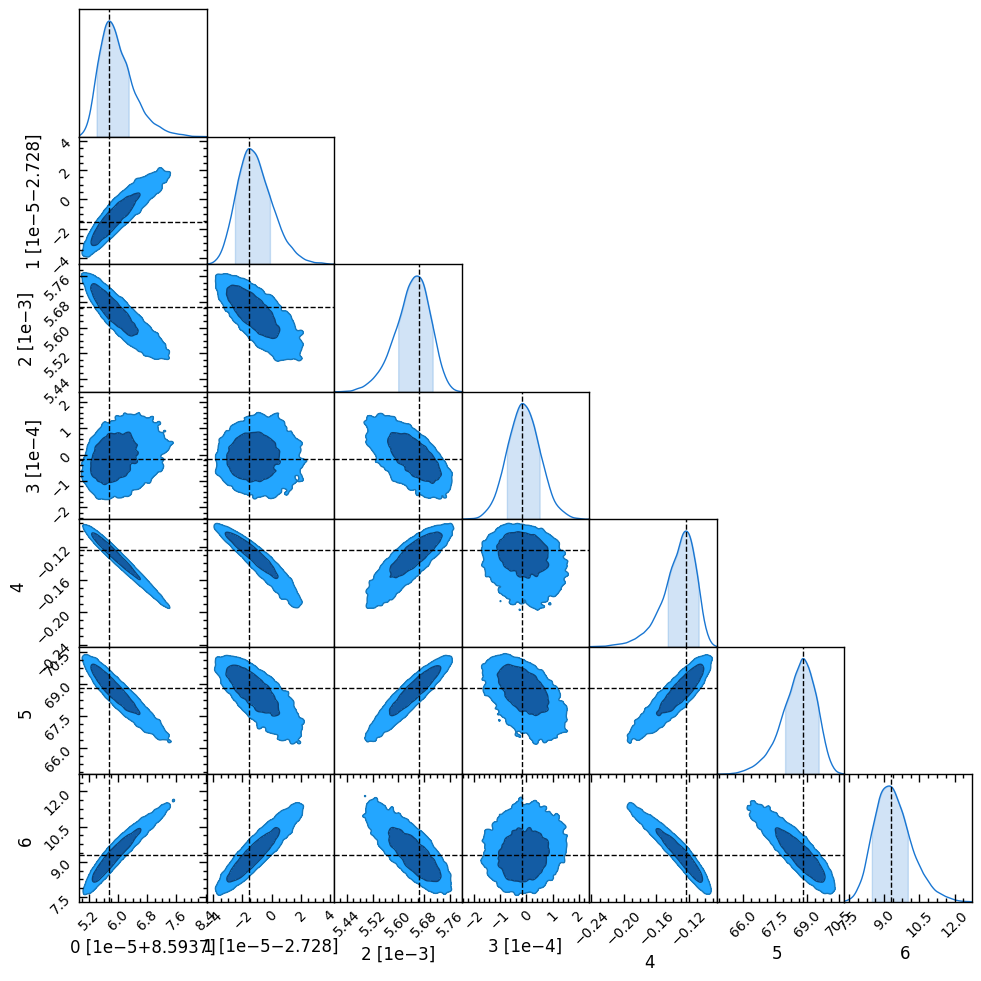

In [16]:
# VISUALISE THE MAX LIKELIHOOD POSITION OF THE NPOLY=4 CHAIN
c = ChainConsumer().add_chain(mcmcChain4[::100], statistics='max')
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_max4 = np.array([val[1] for val in analysis_dict.values()])
f=c.plotter.plot(truth=theta_max4)
plt.show()

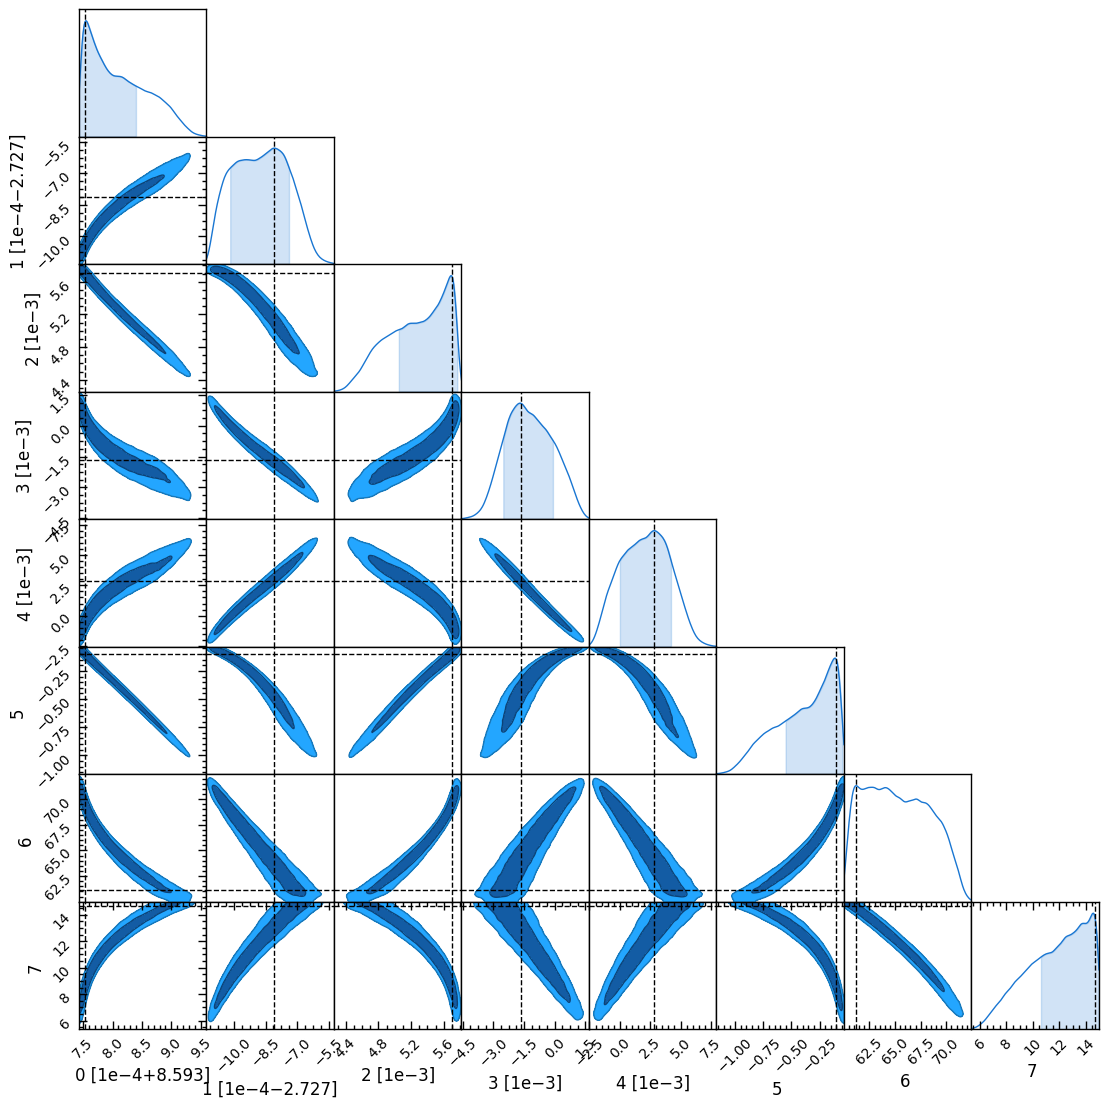

In [17]:
# VISUALISE THE MAXIMUM LIKELIHOOD POSITION OF THE NPOLY=5 CHAIN
c = ChainConsumer().add_chain(mcmcChain5L[::100], statistics='max')
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_max5 = np.array([val[1] for val in analysis_dict.values()])
f=c.plotter.plot(truth=theta_max5)
plt.show()

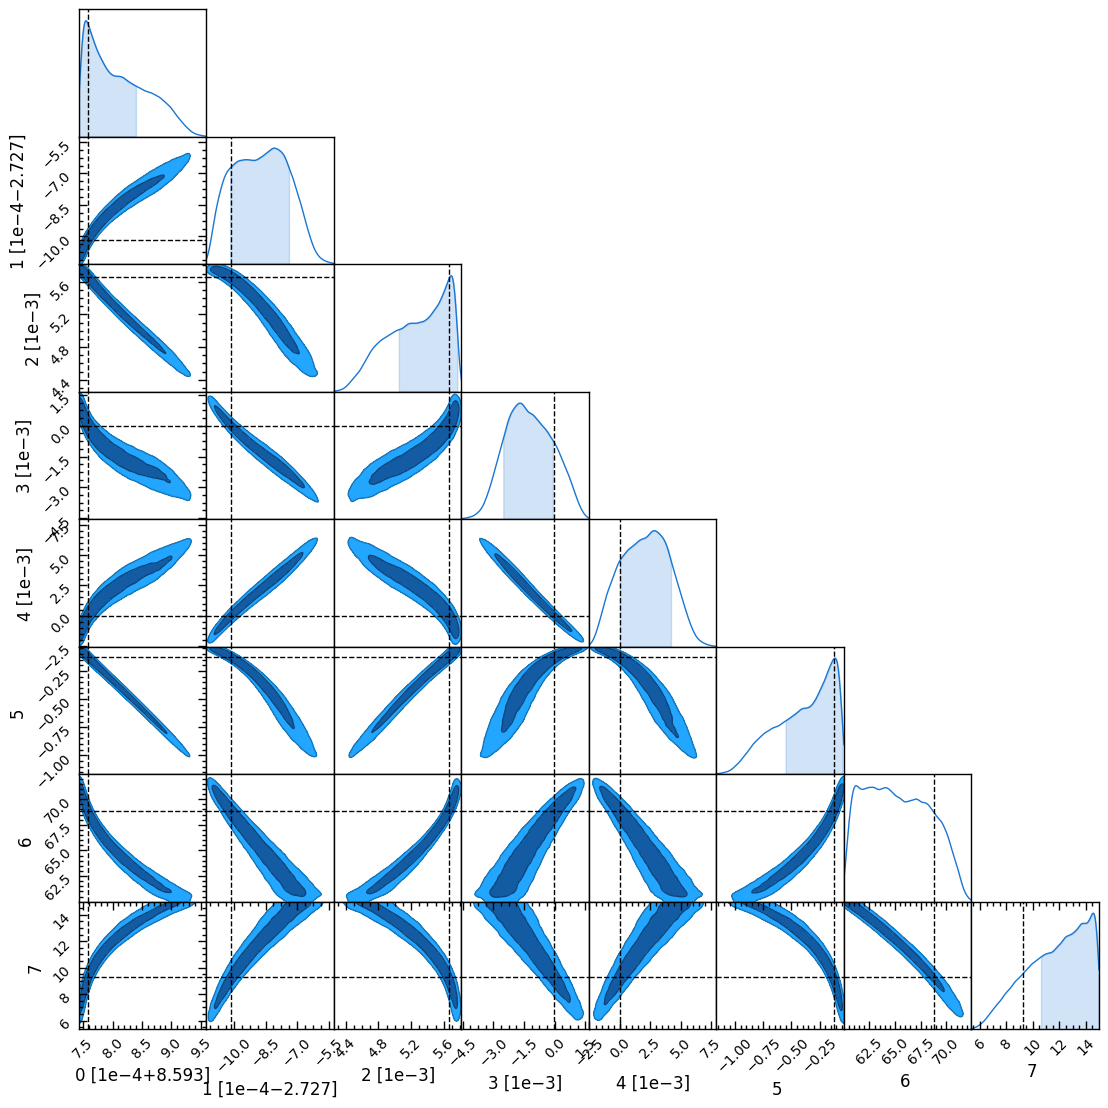

In [20]:
# LOOKING WRONG - THE MAXIMUM LIKELIHOOD MATCHES UP WITH THE 1D POSTERIORS BUT DOESN'T FALL WITHIN THE 2D POSTERIORS.
# CHECK WHAT THE MAX LIKELIHOOD POSITION OF THE NPOLY=4 CASE WITH THE 5TH POLYNOMIAL COEFFICIENT SET TO ZERO LOOKS LIKE.
custom_maxlike_fg = np.append(theta_max4[:-3], 0.)
custom_maxlike    = np.append(custom_maxlike_fg, theta_max4[-3:])
c = ChainConsumer().add_chain(mcmcChain5L[::100])
f=c.plotter.plot(truth=custom_maxlike)
plt.show()

In [26]:
# NOW THIS IS LOOKING MORE CORRECT ON THE 2D POSTERIORS, BUT INCORRECT ON THE 1D POSTERIORS.

# EVALUATE THE LIKELIHOOD OF THE NPOLY=5 CASE AT BOTH WHAT CHAINCONSUMER SAYS IS THE MAX LIKELIHOOD 
# POSITION AND THE CUSTOM MAX LIKELIHOOD BASED ON THE NPOLY=4 CASE.
print("npoly=5 location:", NRI.log_likelihood(theta_max5, dnoisy.vector, noise, mod5))
print("npoly=4 (custom) location:", NRI.log_likelihood(custom_maxlike, dnoisy.vector, noise, mod5))

# COMPARE THIS TO THE NPOLY=4 MAXLIKE CASE:
print("npoly=4 maxlike:", NRI.log_likelihood(theta_max4, dnoisy.vector, noise, mod4))

npoly=5 location: -24084.773133416984
npoly=4 (custom) location: -5.4845328537622
npoly=4 maxlike: -5.4845328537622


In [23]:
# THIS IS BECAUSE THE MLE OF THE 1D POSTERIORS IS NOT THE SAME AS THE MLE OF THE FULL JOINT POSTERIORS.
# HERE'S A VIBECODED IMPLEMENTATION OF A FUNCTION WHICH WILL FIND THE TRUE MLE.

import numpy as np
from scipy import stats
from scipy.optimize import minimize

def find_joint_mode(mcmc_chains: np.ndarray, initial_guess: np.ndarray = None) -> np.ndarray:
    """
    Computes the joint posterior mode from MCMC chains using KDE.

    This function finds the point of highest density in a set of MCMC samples
    by fitting a Kernel Density Estimator (KDE) and then using a numerical
    optimizer to find the peak of that density function.

    Args:
        mcmc_chains (np.ndarray): The MCMC samples, with shape (n_samples, n_parameters).
        initial_guess (np.ndarray, optional): A starting point for the optimization.
                                              If None, the mean of the chains is used.

    Returns:
        np.ndarray: The parameter vector corresponding to the joint mode.
    """
    # 1. Ensure input is a numpy array
    chains = np.asarray(mcmc_chains)
    if chains.ndim == 1:
        chains = chains.reshape(-1, 1)

    # 2. Perform Kernel Density Estimation
    # gaussian_kde expects shape (n_parameters, n_samples)
    kde = stats.gaussian_kde(chains.T)

    # 3. Define the objective function to minimize (the negative log-density)
    def neg_log_density(params):
        return -kde.logpdf(params)

    # 4. Set the starting point for the optimization
    if initial_guess is None:
        initial_guess = np.mean(chains, axis=0)

    # 5. Run the optimization to find the peak of the KDE
    result = minimize(neg_log_density, initial_guess, method='Nelder-Mead')

    return result.x

In [36]:
vibecode_maxlike = find_joint_mode(mcmcChain5L[::100], initial_guess=custom_maxlike)

In [37]:
print("npoly=5 vibecoded location:", NRI.log_likelihood(vibecode_maxlike, dnoisy.vector, noise, mod5))

npoly=5 vibecoded location: -2.9723334397763272


In [38]:
# TEST THE VIBECODED IMPLEMENTATION WITH PUSHVECTORS.
pushvecs = np.eye(len(vibecode_maxlike))*5e-5
all_push = np.sum(pushvecs, axis=1)

print("maxlike:", NRI.log_likelihood(vibecode_maxlike, dnoisy.vector, noise, mod5))
for pushvec in pushvecs:
    print("maxlike offset:", NRI.log_likelihood(vibecode_maxlike+pushvec, dnoisy.vector, noise, mod5))

maxlike: -2.9723334397763272
maxlike offset: -35890.50557621786
maxlike offset: -2766.267563169889
maxlike offset: -455.90967859082525
maxlike offset: -93.73963578513519
maxlike offset: -23.837026187395576
maxlike offset: -2.968946588757228
maxlike offset: -2.972569095263016
maxlike offset: -2.9717914720696657


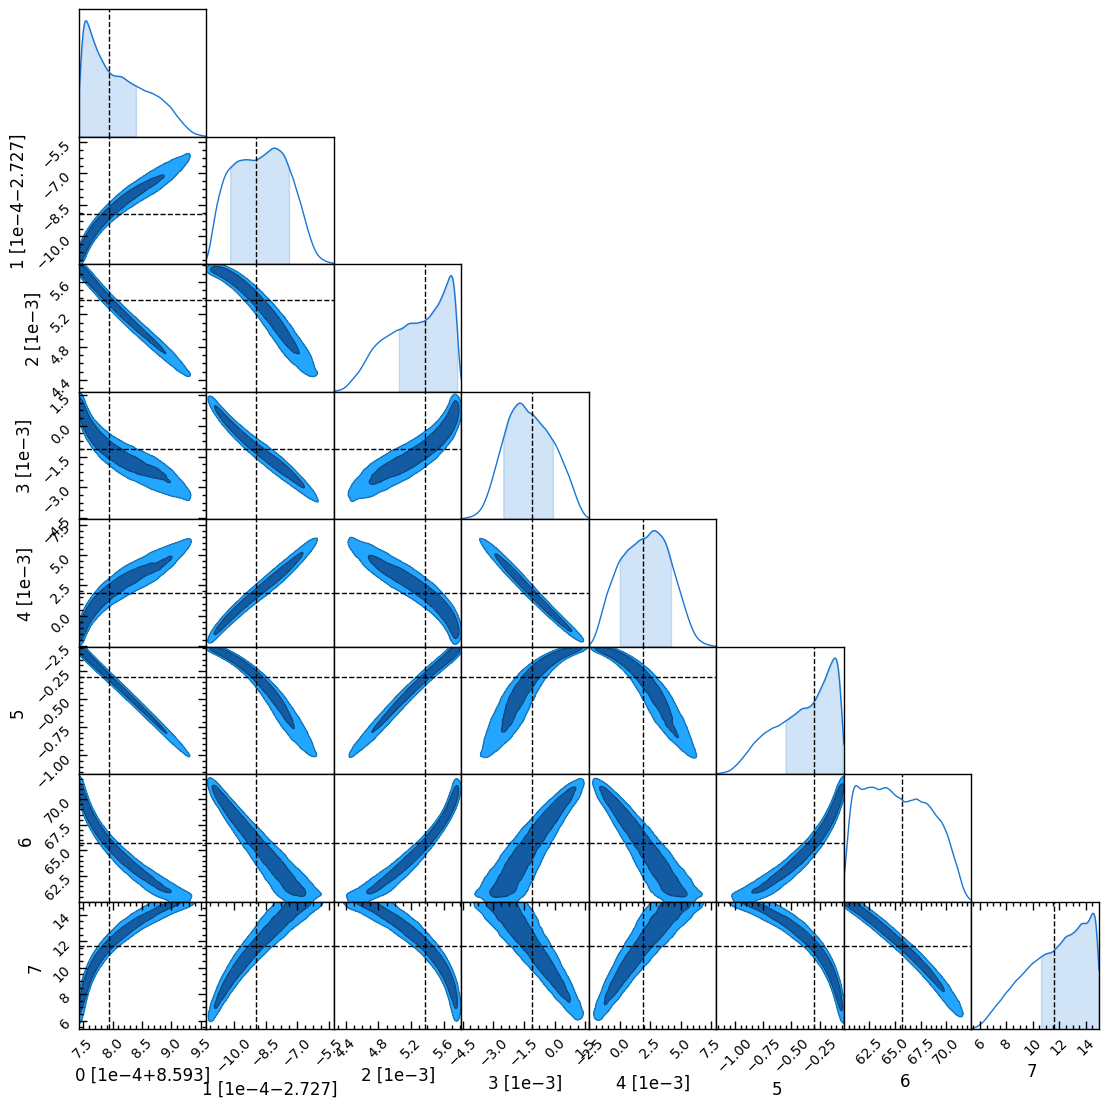

In [39]:
# VISUALISE THE VIBECODED MAXIMUM LIKELIHOOD POSITION OF THE NPOLY=5 CHAIN
c = ChainConsumer().add_chain(mcmcChain5L[::100])
f=c.plotter.plot(truth=vibecode_maxlike)
plt.show()

In [10]:
# GREAT - THINGS ARE LOOKING BETTER. WE NOW NEED TO WRITE A SCRIPT WHICH
# 1. INSTANTIATES EACH MODEL WITH EACH NPOLY
# 2. LOADS THE CORRESPONDING MCMC CHAIN
# 3. COMPUTES THE MLE, USING THE NPOLY=4 MLE WITH ADDED ZEROS TO TOP UP THE POLYNOMIAL ORDER AS A STARTING GUESS
# 4. SAVES THIS IN THE SAME FORMAT AS THE EXISTING CODE

# GENERATE DATA FUNCTION
chrom=None

def gen_data(chrom=None):
    basemap_err = None
    nside   = 32
    lmax    = 32
    Nlmax   = RS.get_size(lmax)
    lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])#np.linspace(-80, 80, 100)#[-26]#
    times = np.linspace(0, 24, 12, endpoint=False)
    Ntau  = 1
    nuarr = np.linspace(50,100,51)
    cm21_params = OBS.cm21_params
    
    # Generate foreground and 21-cm alm
    fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err), err_type='idx')
    cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
    fid_alm  = fg_alm + cm21_alm
    
    # Generate observation matrix for the observations.
    if chrom is None:
        # Generate observation matrix for the achromatic case.
        narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
        mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=True)
        mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
        mat_G = BlockMatrix(mat=mat_G, mode='block', nblock=len(nuarr))
        mat_P = BlockMatrix(mat=mat_P, mode='block', nblock=len(nuarr))
        mat_Y = BlockMatrix(mat=mat_Y, mode='block', nblock=len(nuarr))
        mat_B = BlockMatrix(mat=mat_B, mode='block', nblock=len(nuarr))
    else:
        # Generate observation matrix for the chromatic case.
        chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
        mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(nuarr, nside, lmax, Ntau=Ntau, lats=lats, times=times, return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc)
    
    # Perform fiducial observations without binning.
    d = mat_P @ mat_Y @ mat_B @ fid_alm
    dnoisy, noise_covar = SM.add_noise(d, nuarr[1]-nuarr[0], len(times), t_int=200) # Ntau NOTE: using len(times) here because we keep the data unbinned to apply the chromaticity correction. Noise is recomputed later.
    sample_noise = np.sqrt(noise_covar.block[0][0,0])
    print(f"Data generated with noise {sample_noise} K at 50 MHz in the first bin")
    
    dnoisy_vector = dnoisy.vector
    if chrom is not None:
        # Perform an EDGES-style chromaticity correction.
        # Generate alm of the Haslam-shifted sky and observe them using our beam.
        has_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=True, delta=basemap_err, err_type='bm', seed=124)
        chrom_corr_numerator = mat_P @ mat_Y @ mat_B @ has_alm
        # Construct an observation matrix of the hypothetical (non-chromatic) case.
        mat_B_ref = BlockMatrix(mat=mat_B.block[10], nblock=mat_B.nblock)
        chrom_corr_denom = mat_P @ mat_Y @ mat_B_ref @ has_alm
        chrom_corr = chrom_corr_numerator.vector/chrom_corr_denom.vector
        dnoisy_vector /= chrom_corr
    
    # Bin the noisy data and the noise.
    dnoisy = mat_G@dnoisy_vector
    noise = np.std([np.sqrt(np.diag(noise_covar.block[n])) for n in range(noise_covar.nblock)], axis=1)
    
    return dnoisy.vector, noise, mat_A


In [ ]:
# Set up the foreground models

mod = FM.genopt_binwise_cm21_forward_model(nuarr, mat_A, Npoly=Npoly)

In [58]:
# Generate achromatic data
data, noise, mat_A = gen_data(chrom=None)

# Instantiate Npoly=4 model.
Npolys = [3,4,5,6,7]

for Npoly in Npolys:
    print("\nNpoly:", Npoly)
    
    mod   = FM.genopt_binwise_cm21_forward_model(nuarr, mat_A, Npoly=Npoly)
    
    # Load the corresponding MCMC chain.
    mcmcChain = np.load(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=None, basemap_err=None)
        +'_mcmcChain.npy'
    )
    
    # Compute the chainconsumer estimate of the MLE (max of marginalised posteriors).
    c = ChainConsumer().add_chain(mcmcChain[::100], statistics='max')
    analysis_dict = c.analysis.get_summary(squeeze=True)
    theta_max_est = np.array([val[1] for val in analysis_dict.values()])
    
    # Compute the true MLE.
    theta_max = find_joint_mode(mcmcChain, theta_max_est)
    
    # Compute the value of the BIC.
    loglike_prev = NRI.log_likelihood(theta_max_est, data, noise, mod)
    loglike = NRI.log_likelihood(theta_max, data, noise, mod)
    print("loglikelihood estimate:", loglike_prev)
    print("loglikelihood:", loglike)
    
    bic_prev = len(theta_max)*np.log(len(data)) - 2*loglike_prev
    bic = len(theta_max)*np.log(len(data)) - 2*loglike
    print("BIC estimate:", bic_prev)
    print("BIC:", bic)
    
    np.save(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=None, basemap_err=None)
        +'_bic_new.npy',
        bic
    )

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin

Npoly: 3
loglikelihood estimate: -4.004268081570719
loglikelihood: -1.8369334459167956
BIC estimate: 31.599489959487393
BIC: 27.264820688179544

Npoly: 4


loglikelihood estimate: -5.4845328537622
loglikelihood: -1.7791346415497262
BIC estimate: 38.49184513659468
BIC: 31.081048712169732

Npoly: 5


loglikelihood estimate: -11365.613621904356
loglikelihood: -36.887935052422556
BIC estimate: 22762.681848870507
BIC: 105.23047516663972

Npoly: 6


loglikelihood estimate: -2391.8884693776963
loglikelihood: -2.840322937006532
BIC estimate: 4819.163369449911
BIC: 41.067076568531995

Npoly: 7
loglikelihood estimate: -111194.77591925202
loglikelihood: -645.6962063427762
BIC estimate: 222428.87009483128
BIC: 1330.7106690127957


In [61]:
# Generate small chrom data
chrom = 1.6e-2
chromstr = '1.6e-02'
data, noise, mat_A = gen_data(chrom=chrom)

# Instantiate Npoly=4 model.
Npolys = [3,4,5,6,7]

for Npoly in Npolys:
    print("\nNpoly:", Npoly)
    
    mod   = FM.genopt_binwise_cm21_forward_model(nuarr, mat_A, Npoly=Npoly)
    
    # Load the corresponding MCMC chain.
    mcmcChain = np.load(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=chromstr, basemap_err=None)
        +'_mcmcChain.npy'
    )
    
    # Compute the chainconsumer estimate of the MLE (max of marginalised posteriors).
    c = ChainConsumer().add_chain(mcmcChain[::100], statistics='max')
    analysis_dict = c.analysis.get_summary(squeeze=True)
    theta_max_est = np.array([val[1] for val in analysis_dict.values()])
    
    # Compute the true MLE.
    theta_max = find_joint_mode(mcmcChain, theta_max_est)
    
    # Compute the value of the BIC.
    loglike_prev = NRI.log_likelihood(theta_max_est, data, noise, mod)
    loglike = NRI.log_likelihood(theta_max, data, noise, mod)
    print("loglikelihood estimate:", loglike_prev)
    print("loglikelihood:", loglike)
    
    bic_prev = len(theta_max)*np.log(len(data)) - 2*loglike_prev
    bic = len(theta_max)*np.log(len(data)) - 2*loglike
    print("BIC estimate:", bic_prev)
    print("BIC:", bic)
    
    np.save(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=chromstr, basemap_err=None)
        +'_bic_new.npy',
        bic
    )

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.03196626287899847 K at 50 MHz in the first bin
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561



Npoly: 3


loglikelihood estimate: -1207811.244473618
loglikelihood: -1207467.2466906165
BIC estimate: 2415646.079901032
BIC: 2414958.084335029

Npoly: 4


loglikelihood estimate: -500949.7749048855
loglikelihood: -186709.66608485527
BIC estimate: 1001927.0725892001
BIC: 373446.85494913964

Npoly: 5


loglikelihood estimate: -9.685353806900018
loglikelihood: -5.662261012537554
BIC estimate: 50.825312675594645
BIC: 42.779127086869714

Npoly: 6


loglikelihood estimate: -1430.545513128358
loglikelihood: -7.474375480245071
BIC estimate: 2896.4774569512347
BIC: 50.335181655009066

Npoly: 7
loglikelihood estimate: -26094.565341866517
loglikelihood: -3.280858738610291
BIC estimate: 52228.448940060276
BIC: 45.87997380446384


In [62]:
# Generate big chrom data
chrom = 3.4e-2
chromstr = '3.4e-02'
data, noise, mat_A = gen_data(chrom=chrom)

# Instantiate Npoly=4 model.
Npolys = [3,4,5,6,7]

for Npoly in Npolys:
    print("\nNpoly:", Npoly)
    
    mod   = FM.genopt_binwise_cm21_forward_model(nuarr, mat_A, Npoly=Npoly)
    
    # Load the corresponding MCMC chain.
    mcmcChain = np.load(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=chromstr, basemap_err=None)
        +'_mcmcChain.npy'
    )
    
    # Compute the chainconsumer estimate of the MLE (max of marginalised posteriors).
    c = ChainConsumer().add_chain(mcmcChain[::100], statistics='max')
    analysis_dict = c.analysis.get_summary(squeeze=True)
    theta_max_est = np.array([val[1] for val in analysis_dict.values()])
    
    # Compute the true MLE.
    theta_max = find_joint_mode(mcmcChain, theta_max_est)
    
    # Compute the value of the BIC.
    loglike_prev = NRI.log_likelihood(theta_max_est, data, noise, mod)
    loglike = NRI.log_likelihood(theta_max, data, noise, mod)
    print("loglikelihood estimate:", loglike_prev)
    print("loglikelihood:", loglike)
    
    bic_prev = len(theta_max)*np.log(len(data)) - 2*loglike_prev
    bic = len(theta_max)*np.log(len(data)) - 2*loglike
    print("BIC estimate:", bic_prev)
    print("BIC:", bic)
    
    np.save(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=chromstr, basemap_err=None)
        +'_bic_new.npy',
        bic
    )

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.03196626287899847 K at 50 MHz in the first bin
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561

Npoly: 3
loglikelihood estimate: -1941391.7530047272
loglikelihood: -1942846.9712688145
BIC estimate: 3882807.0969632505
BIC: 3885717.533491425

Npoly: 4
loglikelihood estimate: -105490.40237239467
loglikelihood: -105491.26944356567
BIC estimate: 211008.32752421842
BIC: 211010.06166656042

Npoly: 5


loglikelihood estimate: -66.8626061159843
loglikelihood: -58.31498601906407
BIC estimate: 165.17981729376322
BIC: 148.08457709992274

Npoly: 6


loglikelihood estimate: -96.47222522705616
loglikelihood: -36.58746737188698
BIC estimate: 228.33088114863125
BIC: 108.56136543829288

Npoly: 7
loglikelihood estimate: -611001.0976979905
loglikelihood: -1719.379238482173
BIC estimate: 1222041.5136523081
BIC: 3478.076733291589


In [66]:
mcmcChain7.shape

(1600000, 10)

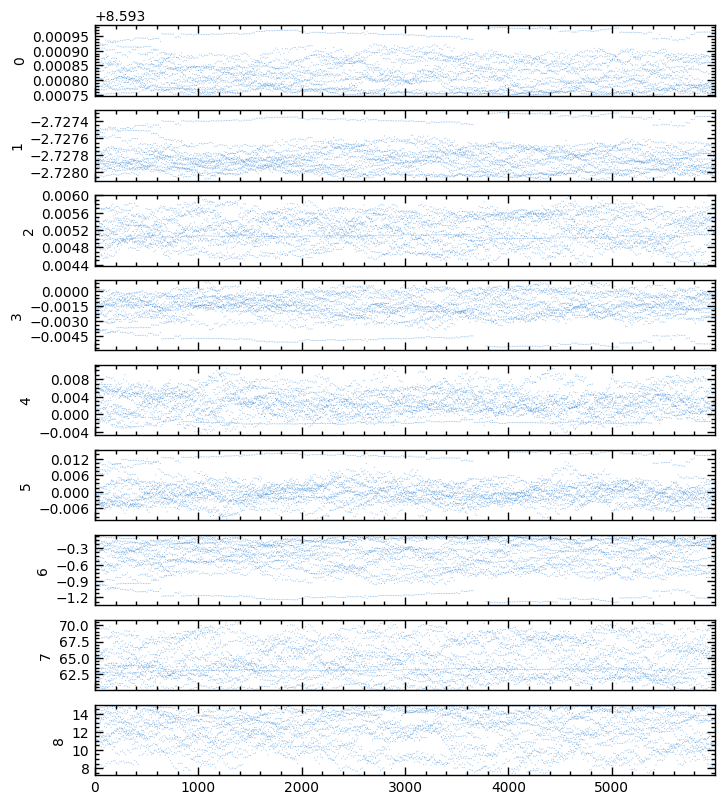

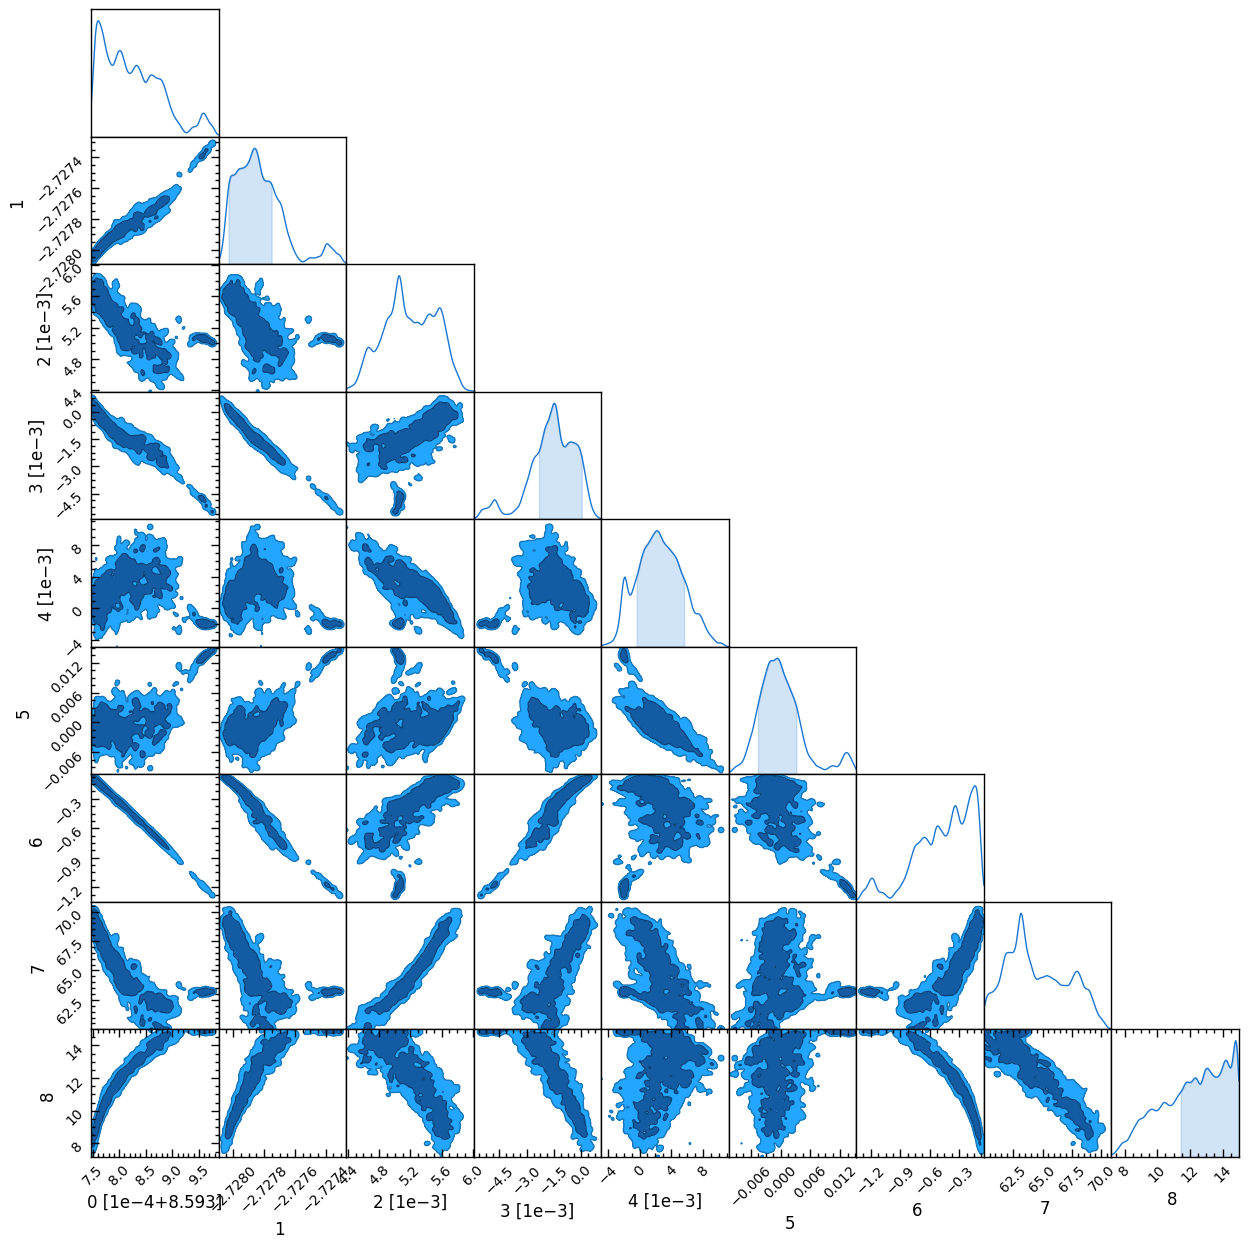

In [68]:
mcmcChain7 = np.load(
    'saves/Binwise/'
    +construct_runstr(Nant=7, Npoly=6, chromstr=None, basemap_err=None)
    +'_mcmcChain.npy'
)
c = ChainConsumer().add_chain(mcmcChain7[1000000::100])
f=c.plotter.plot_walks()
plt.show()
f=c.plotter.plot()
plt.show()

In [69]:
# Looks like I will additionally have to run longer chains
# Run a longer chain
for Npoly in [3, 4, 6, 7]:
    fg.fg_cm21_chrom_corr(Npoly=Npoly, mcmc=True, chrom=None, savetag='L', lats=fg.ant_LUT[7], mcmc_pos=None, basemap_err=None, steps=500000, burn_in=300000, fidmap_HS=False)
    

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59373755e+00 -2.72811299e+00  5.95577809e-03]
std devs: [1.01634330e-06 7.62075128e-06 1.95238471e-05]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [14:05<00:00, 591.36it/s]


bic is  27.861792275141195
saving bic
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59373798e+00 -2.72811249e+00  5.92900245e-03  5.31429839e-05]
std devs: [1.36340924e-06 7.75940476e-06 5.78204739e-05 1.07261759e-04]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [13:52<00:00, 600.70it/s]


bic is  33.86281145277431
saving bic
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59374224e+00 -2.72816218e+00  5.57655667e-03  2.03218634e-03
  4.79846049e-05 -4.81307519e-03]
std devs: [4.64735227e-07 4.49119509e-06 2.51924001e-05 1.30654515e-04
 3.20628471e-04 3.76188127e-04]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [12:16<00:00, 678.68it/s]


bic is  9117.161662248207
saving bic
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59374388e+00 -2.72816517e+00  5.23324046e-03  2.96899664e-03
  8.15970356e-03 -4.01862838e-02  3.63663031e-02]
std devs: [2.40462321e-07 2.66176815e-06 3.04802443e-05 1.05086157e-04
 7.68902716e-04 2.73278290e-03 2.70591725e-03]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [12:00<00:00, 694.04it/s]


bic is  475045.565992443
saving bic


In [71]:
mcmcChain.shape

(12800000, 9)

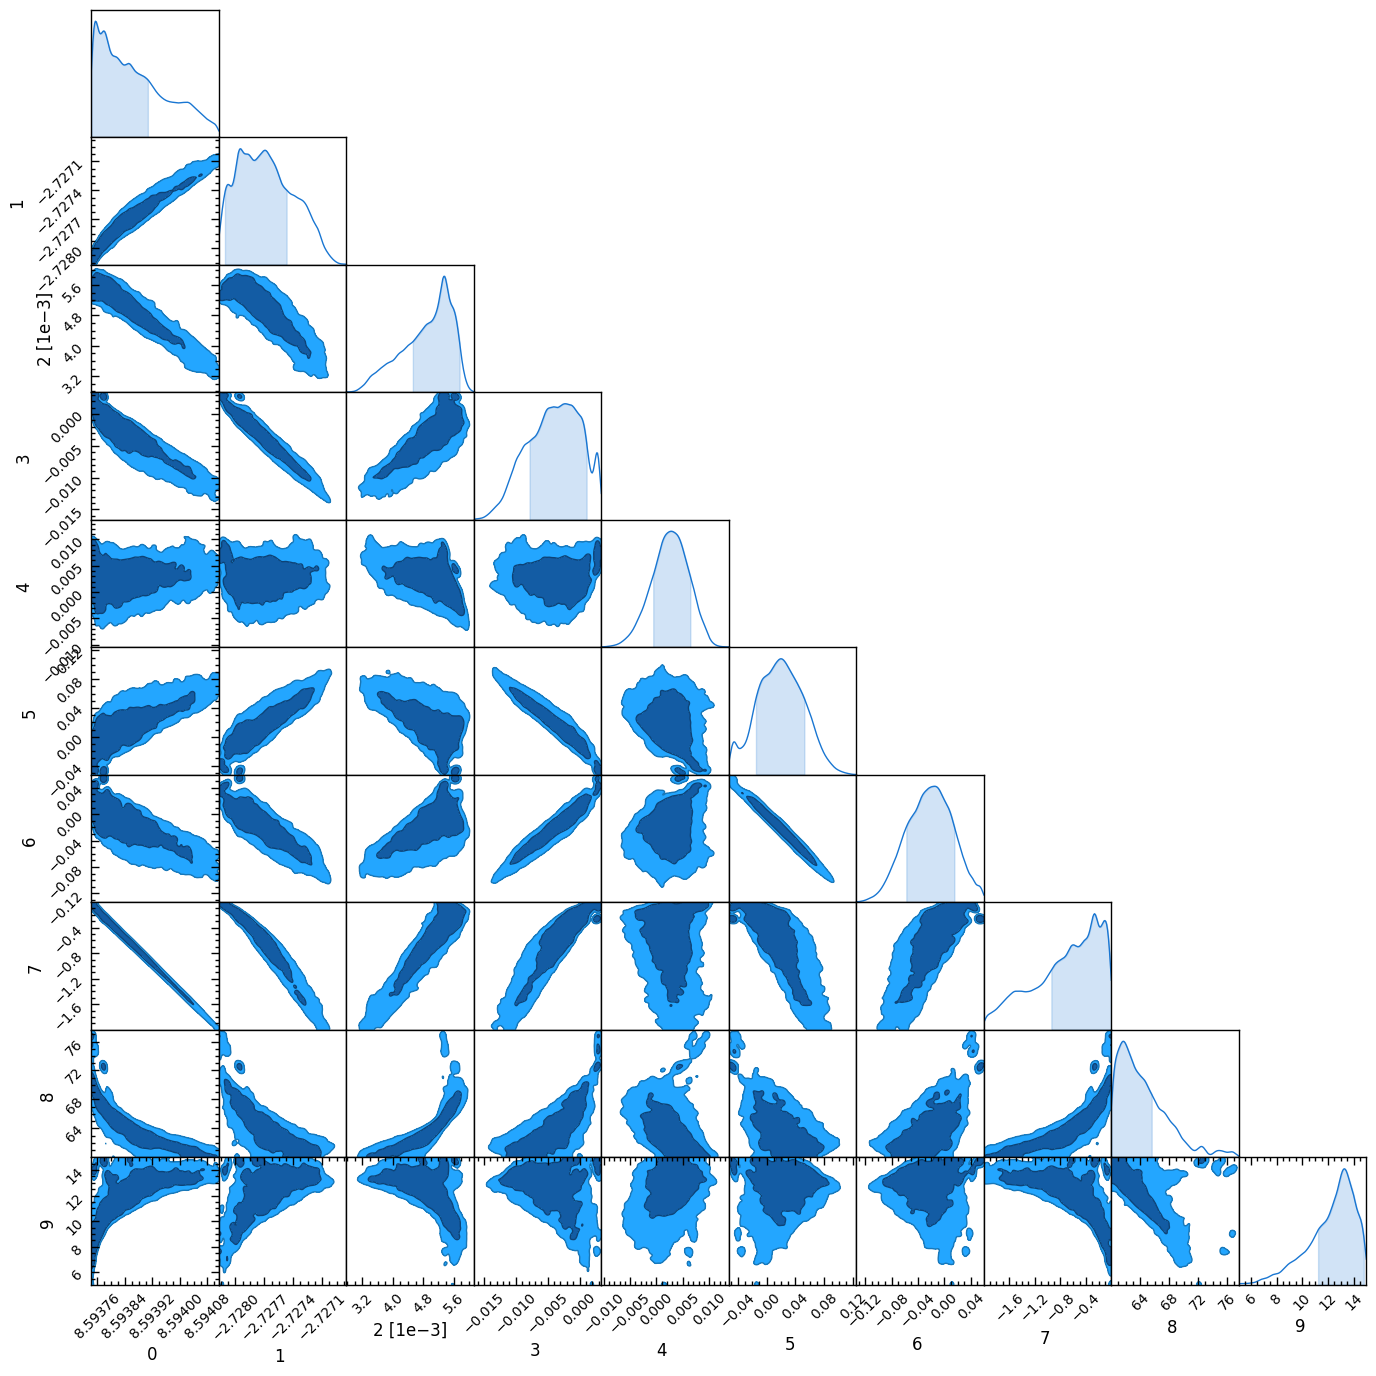

In [75]:
mcmcChain = np.load(
    'saves/Binwise/'
    +construct_runstr(Nant=7, Npoly=7, chromstr=None, basemap_err=None)
    +'L'
    +'_mcmcChain.npy'
)
c = ChainConsumer().add_chain(mcmcChain[10000000:])
'''f=c.plotter.plot_walks()
plt.show()'''
f=c.plotter.plot()
plt.show()

In [77]:
# REPEAT FOR LONGER-RUN ACHROMATIC CASE

# Generate achromatic data
data, noise, mat_A = gen_data(chrom=None)

# Instantiate Npoly=4 model.
Npolys = [3,4,5,6,7]

for Npoly in Npolys:
    print("\nNpoly:", Npoly)
    
    mod   = FM.genopt_binwise_cm21_forward_model(nuarr, mat_A, Npoly=Npoly)
    
    # Load the corresponding MCMC chain.
    mcmcChain = np.load(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=None, basemap_err=None)
        +'L'
        +'_mcmcChain.npy'
    )
    
    # Compute the chainconsumer estimate of the MLE (max of marginalised posteriors).
    c = ChainConsumer().add_chain(mcmcChain[10000000:], statistics='max')
    analysis_dict = c.analysis.get_summary(squeeze=True)
    theta_max_est = np.array([val[1] for val in analysis_dict.values()])
    
    # Compute the true MLE.
    theta_max = find_joint_mode(mcmcChain, theta_max_est)
    
    # Compute the value of the BIC.
    loglike_prev = NRI.log_likelihood(theta_max_est, data, noise, mod)
    loglike = NRI.log_likelihood(theta_max, data, noise, mod)
    print("loglikelihood estimate:", loglike_prev)
    print("loglikelihood:", loglike)
    
    bic_prev = len(theta_max)*np.log(len(data)) - 2*loglike_prev
    bic = len(theta_max)*np.log(len(data)) - 2*loglike
    print("BIC estimate:", bic_prev)
    print("BIC:", bic)
    
    np.save(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=None, basemap_err=None)
        +'L'
        +'_bic_new.npy',
        bic
    )

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin

Npoly: 3
loglikelihood estimate: -2.6531028481220673
loglikelihood: -1.7804868152627675
BIC estimate: 28.897159492590088
BIC: 27.151927426871488

Npoly: 4
loglikelihood estimate: -3.208590857641646
loglikelihood: -1.7520938766413583
BIC estimate: 33.939961144353575
BIC: 31.026967182352998

Npoly: 5
loglikelihood estimate: -30804.17510898829
loglikelihood: -509.03741185374963
BIC estimate: 61639.80482303837
BIC: 1049.5294287692939

Npoly: 6


loglikelihood estimate: -3678.305847066588
loglikelihood: -108.52488235697551
BIC estimate: 7391.9981248276945
BIC: 252.43619540846996

Npoly: 7
loglikelihood estimate: -110077.64676135624
loglikelihood: -34.305705398821644
BIC estimate: 220194.61177903973
BIC: 107.92966712488655


In [4]:
# Looks like I will additionally have to run longer chains AND maybe increase the number of walkers
for Npoly in [3, 4, 5, 6, 7]:
    mcmcChain = np.load(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=None, basemap_err=None)
        +'L'
        +'_mcmcChain.npy'
    )
    initpos = np.mean(mcmcChain, axis=0)
    fg.fg_cm21_chrom_corr(Npoly=Npoly, mcmc=True, chrom=None, savetag='LW', lats=fg.ant_LUT[7], mcmc_pos=initpos, basemap_err=None, steps=500000, burn_in=300000, fidmap_HS=False)
    

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59373755e+00 -2.72811299e+00  5.95577809e-03]
std devs: [1.01634330e-06 7.62075128e-06 1.95238471e-05]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [46:10<00:00, 180.50it/s]


bic is  28.734326597307465
saving bic
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59373798e+00 -2.72811249e+00  5.92900245e-03  5.31429839e-05]
std devs: [1.36340924e-06 7.75940476e-06 5.78204739e-05 1.07261759e-04]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [46:45<00:00, 178.21it/s]


bic is  36.38705256412135
saving bic
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59374175e+00 -2.72818261e+00  5.68955394e-03  2.71331029e-03
 -3.98253362e-03]
std devs: [5.13575981e-07 4.62047467e-06 2.41217814e-05 1.47668847e-04
 2.13544561e-04]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [40:44<00:00, 204.51it/s]


bic is  62566.78861564847
saving bic
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59374224e+00 -2.72816218e+00  5.57655667e-03  2.03218634e-03
  4.79846049e-05 -4.81307519e-03]
std devs: [4.64735227e-07 4.49119509e-06 2.51924001e-05 1.30654515e-04
 3.20628471e-04 3.76188127e-04]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [40:39<00:00, 204.99it/s]


bic is  15721.962109078651
saving bic
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59374388e+00 -2.72816517e+00  5.23324046e-03  2.96899664e-03
  8.15970356e-03 -4.01862838e-02  3.63663031e-02]
std devs: [2.40462321e-07 2.66176815e-06 3.04802443e-05 1.05086157e-04
 7.68902716e-04 2.73278290e-03 2.70591725e-03]
MCMC PRIORS: [[ 1.00e+00  2.50e+01]
 [-3.50e+00 -1.50e+00]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-1.00e+01  1.01e+01]
 [-2.00e+00 -1.00e-03]
 [ 6.00e+01  9.00e+01]
 [ 5.00e+00  1.50e+01]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [40:09<00:00, 207.51it/s]


bic is  102867.43834646007
saving bic


In [12]:
mcmcChain.shape

(12800000, 8)

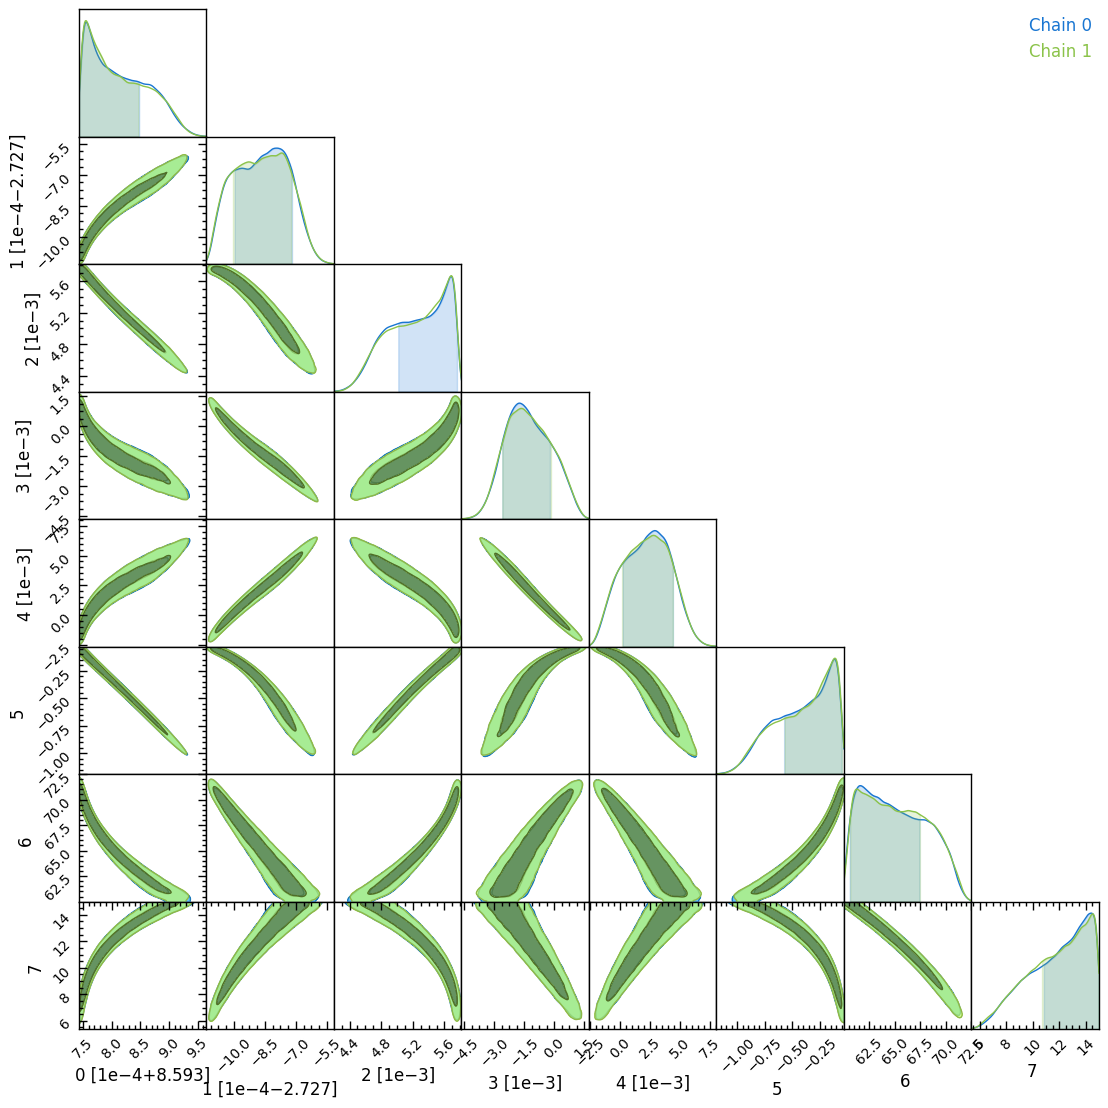

In [17]:
# So what's going on here? Looks like running longer chains isn't making them clearer/finding the right spot in posterior space.
mcmcChain = np.load(
    'saves/Binwise/'
    +construct_runstr(Nant=7, Npoly=5, chromstr=None, basemap_err=None)
    +'LW'
    +'_mcmcChain.npy'
)
c = ChainConsumer().add_chain(mcmcChain[25000000::100])

mcmcChain = np.load(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=5, chromstr=None, basemap_err=None)
        +'L'
        +'_mcmcChain.npy'
)
c.add_chain(mcmcChain[10000000::10])
'''f=c.plotter.plot_walks()
plt.show()'''
f=c.plotter.plot()
plt.show()

In [ ]:
# Soo looking at the above figure, we see that the blue (increased walkers and longer chain) is slightly different to 
# the green (longer chain only), which may imply that the BIC estimate will be better with the blue chain.
# AND ACTUALLY I was burning in the first 10 million points, which is too much given the chain length was 16 million.

In [24]:
# REPEAT FOR LONGER-RUN ACHROMATIC CASE

# Generate achromatic data
data, noise, mat_A = gen_data(chrom=None)

Npolys = [5]

for Npoly in Npolys:
    print("\nNpoly:", Npoly)
    
    mod   = FM.genopt_binwise_cm21_forward_model(nuarr, mat_A, Npoly=Npoly)
    
    # Load the corresponding MCMC chain.
    mcmcChain = np.load(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=None, basemap_err=None)
        +'LW'
        +'_mcmcChain.npy'
    )
    
    # Compute the chainconsumer estimate of the MLE (max of marginalised posteriors).
    c = ChainConsumer().add_chain(mcmcChain[10000000:], statistics='max')
    analysis_dict = c.analysis.get_summary(squeeze=True)
    theta_max_est = np.array([val[1] for val in analysis_dict.values()])
    
    # Compute the true MLE.
    theta_max = find_joint_mode(mcmcChain, theta_max_est)
    
    # Compute the value of the BIC.
    loglike_prev = NRI.log_likelihood(theta_max_est, data, noise, mod)
    loglike = NRI.log_likelihood(theta_max, data, noise, mod)
    print("loglikelihood estimate:", loglike_prev)
    print("loglikelihood:", loglike)
    
    bic_prev = len(theta_max)*np.log(len(data)) - 2*loglike_prev
    bic = len(theta_max)*np.log(len(data)) - 2*loglike
    print("BIC estimate:", bic_prev)
    print("BIC:", bic)
    
    np.save(
        'saves/Binwise/'
        +construct_runstr(Nant=7, Npoly=Npoly, chromstr=None, basemap_err=None)
        +'LW'
        +'_bic_new.npy',
        bic
    )

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin

Npoly: 5
loglikelihood estimate: -30343.21574663754
loglikelihood: -669.2103597061802
BIC estimate: 60717.88609833687
BIC: 1369.875324474155


In [25]:
print('done')

done


In [26]:
'saves/Binwise/'+construct_runstr(Nant=7, Npoly=Npoly, chromstr=None, basemap_err=None)+'LW'+'_bic_new.npy'

'saves/Binwise/Nant<7>_Npoly<5>_achromLW_bic_new.npy'

In [3]:
from binwise_modelling import fg_cm21_chrom_corr

In [4]:
# Try maximum-likelihood methods of calculating the BIC.
fg_cm21_chrom_corr(Npoly=3, mcmc=False, chrom=None, basemap_err=None, savetag='M', times=None, lats=None, mcmc_pos=None)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59373755e+00 -2.72811299e+00  5.95577809e-03]
std devs: [1.01634330e-06 7.62075128e-06 1.95238471e-05]
Maximising likelihood succeeded
par est: [ 8.59375766e+00 -2.72801640e+00  5.65758806e-03 -1.23221190e-01
  6.88775014e+01  9.03657821e+00]
bic is  27.123743512291455
given by 23.590953796345953 - 2x-1.7663948579727502
saving bic


In [5]:
fg_cm21_chrom_corr(Npoly=4, mcmc=False, chrom=None, basemap_err=None, savetag='M', times=None, lats=None, mcmc_pos=None)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59373798e+00 -2.72811249e+00  5.92900245e-03  5.31429839e-05]
std devs: [1.36340924e-06 7.75940476e-06 5.78204739e-05 1.07261759e-04]
Maximising likelihood succeeded
par est: [ 8.59375737e+00 -2.72801642e+00  5.66570506e-03 -1.44475001e-05
 -1.22460422e-01  6.89683294e+01  9.01600336e+00]
bic is  30.995100145645544
given by 27.52277942907028 - 2x-1.7361603582876333
saving bic


In [6]:
fg_cm21_chrom_corr(Npoly=5, mcmc=False, chrom=None, basemap_err=None, savetag='M', times=None, lats=None, mcmc_pos=None)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59374175e+00 -2.72818261e+00  5.68955394e-03  2.71331029e-03
 -3.98253362e-03]
std devs: [5.13575981e-07 4.62047467e-06 2.41217814e-05 1.47668847e-04
 2.13544561e-04]
Maximising likelihood succeeded
par est: [ 8.59375305e+00 -2.72804103e+00  5.70050174e-03  2.71610951e-04
 -4.48238122e-04 -9.87669680e-02  6.95894849e+01  8.42313732e+00]
bic is  34.85091738005189
given by 31.454605061794606 - 2x-1.698156159128642
saving bic


In [4]:
fg_cm21_chrom_corr(Npoly=6, mcmc=False, chrom=None, basemap_err=None, savetag='M', times=None, lats=None, mcmc_pos=None)
fg_cm21_chrom_corr(Npoly=7, mcmc=False, chrom=None, basemap_err=None, savetag='M', times=None, lats=None, mcmc_pos=None)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59374224e+00 -2.72816218e+00  5.57655667e-03  2.03218634e-03
  4.79846049e-05 -4.81307519e-03]
std devs: [4.64735227e-07 4.49119509e-06 2.51924001e-05 1.30654515e-04
 3.20628471e-04 3.76188127e-04]
Maximising likelihood succeeded
par est: [ 8.59375036e+00 -2.72806100e+00  5.65426812e-03  4.29727873e-04
  4.80985375e-04 -1.72290810e-03 -7.82424298e-02  6.96060229e+01
  7.78433904e+00]
bic is  38.230126081344736
given by 35.38643069451893 - 2x-1.4218476934129043
saving bic
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.0345939942388699 K at 50 MHz in the first bin
par est: [ 8.59374388e+00 -2.72816517e+00  5.23324046e-03  2.96899664e-03
  8.15970356e-03 -4.01862838e-02  3.63663031e-02]
std devs: [2.40462321e-07 2.66176815e-06 3.04802443e-05 1.05086157e-04
 7.68902716e-04 2.73278290e-03 2.70591725e-03]
Maximising likelihood succeeded
par est: [ 8.59375307e+00 -2.72803974e+00  5.65835649e-03  5.09745378e-05
  2.77677681e-04  1.34111180e-03 -3.20167113e-03 -9.57532353e-02
  6.91434274e+01  8.15208516e+00]
bic is  42.1122904420821
given by 39.318256327243255 - 2x-1.3970170574194227
saving bic


In [3]:
# Success!!!
# Repeat for the chromatic cases
fg_cm21_chrom_corr(Npoly=3, mcmc=False, chrom=1.6e-2, basemap_err=None, savetag='M', times=None, lats=None, mcmc_pos=None)
fg_cm21_chrom_corr(Npoly=3, mcmc=False, chrom=1.6e-2, basemap_err=None, savetag='M', times=None, lats=None, mcmc_pos=None)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.03196626287899847 K at 50 MHz in the first bin
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
par est: [ 8.59175932e+00 -2.73433530e+00 -1.87542025e-03]
std devs: [2.50617131e-05 1.86688437e-04 4.58678673e-04]


/Users/yordani/Documents/wonky_compass/sky-observer2/venvskob/lib/python3.10/site-packages/scipy/optimize/_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Exception: Maximum number of iterations has been exceeded.

In [ ]:
fg_cm21_chrom_corr(Npoly=4, mcmc=False, chrom=1.6e-2, basemap_err=None, savetag='M', times=None, lats=None, mcmc_pos=None)


In [2]:
fg_cm21_chrom_corr(Npoly=5, mcmc=False, chrom=1.6e-2, basemap_err=None, savetag='M', times=None, lats=None, mcmc_pos=None)


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Using GSMA foregrounds with basemap error None


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Data generated with noise 0.03196626287899847 K at 50 MHz in the first bin
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
par est: [ 8.59188494e+00 -2.73367802e+00 -9.46867865e-03  2.35165692e-03
  2.18049422e-02]
std devs: [4.99081285e-07 4.33011119e-06 2.34116623e-05 1.38576378e-04
 1.95385449e-04]
using p0 from chromatic 1.6e-2 estimate


/Users/yordani/Documents/wonky_compass/sky-observer2/venvskob/lib/python3.10/site-packages/scipy/optimize/_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Exception: Maximum number of iterations has been exceeded.

In [8]:
np.load('saves/Binwise/'+construct_runstr(Nant=7, Npoly=3, chromstr=None, basemap_err=None)+'M'+'_maxliketheta.npy')

array([ 8.59375766e+00, -2.72801640e+00,  5.65758590e-03, -1.23222253e-01,
        6.88774873e+01,  9.03663239e+00])